문서 유사도

In [4]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm

    return similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends',
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)    

(3, 18)


In [ ]:
# TFidfVectorizer로 transform()한 결과는 희소 행렬이므로 밀집 행렬로 변환
# cos_similarity 함수의 인자인 array로 만들기 위함
feature_vect_dense = feature_vect_simple.todense()

vect1 = np.array(feature_vect_dense[0]).reshape(-1, )   # reshape(-1, ) : 자동으로 갯수 계산해서 정렬
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )

# 첫 번째 문장과 두 번째 문장의 피처 벡터로 두 개의 문장의 코사인 유사도 추출
similarity_simple = cos_similarity(vect1, vect2)
print('문장 1, 문장 2의 cosine 유사도 : {0:.3f}'.format(similarity_simple))

문장 1, 문장 2의 cosine 유사도 : 0.402


In [7]:
similarity_simple = cos_similarity(vect1, vect3)
print('문장 1, 문장 3의 cosine 유사도 : {0:.3f}'.format(similarity_simple))

similarity_simple = cos_similarity(vect2, vect3)
print('문장 2, 문장 3의 cosine 유사도 : {0:.3f}'.format(similarity_simple))

문장 1, 문장 3의 cosine 유사도 : 0.404
문장 2, 문장 3의 cosine 유사도 : 0.456


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [9]:
similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print(similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
(3, 3)


Opinion Review 데이터 셋을 이용한 문서 유사도 측정

In [11]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [27]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
path = './topics'
all_files = glob.glob(os.path.join(path, "*.data"))
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    filename_ = file_.split('/')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

In [29]:
document_df.head(10)

,filename,opinion_text,cluster_label
0,battery-life_ipod_nano_8gb,...,1
1,gas_mileage_toyota_camry_2007,...,2
2,room_holiday_inn_london,...,0
3,location_holiday_inn_london,...,0
4,staff_bestwestern_hotel_sfo,...,0
5,voice_garmin_nuvi_255W_gps,...,1
6,speed_garmin_nuvi_255W_gps,...,1
7,size_asus_netbook_1005ha,...,1
8,screen_garmin_nuvi_255W_gps,...,1
9,battery-life_amazon_kindle,...,1


In [30]:
hotel_indexes = document_df[document_df['cluster_label'] == 2].index
hotel_indexes

Index([1, 18, 22, 23, 29, 35, 42, 43, 45, 47], dtype='int64')

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

car_indexes = document_df[document_df['cluster_label'] == 2].index
print('자동차로 클러스터링 된 문서들의 DataFrame Index : ', car_indexes)

comparison_docname = document_df.iloc[car_indexes[0]]['filename']
print('##### 비교 기준 문서명 ', comparison_docname, '와 타 문서 유사도 #####')

similarity_pair = cosine_similarity(feature_vect[car_indexes[0]], feature_vect[car_indexes])
print(similarity_pair)

자동차로 클러스터링 된 문서들의 DataFrame Index :  Index([1, 18, 22, 23, 29, 35, 42, 43, 45, 47], dtype='int64')
##### 비교 기준 문서명  gas_mileage_toyota_camry_2007 와 타 문서 유사도 #####
[[1.         0.15655631 0.0879083  0.08217817 0.06276647 0.96608144
  0.14398794 0.27273923 0.05452321 0.20206332]]


가장 유사도가 큰 파일명 및 유사도:
 filename      mileage_honda_accord_2008
similarity                     0.966081
Name: 35, dtype: object


Text(0.5, 1.0, 'gas_mileage_toyota_camry_2007')

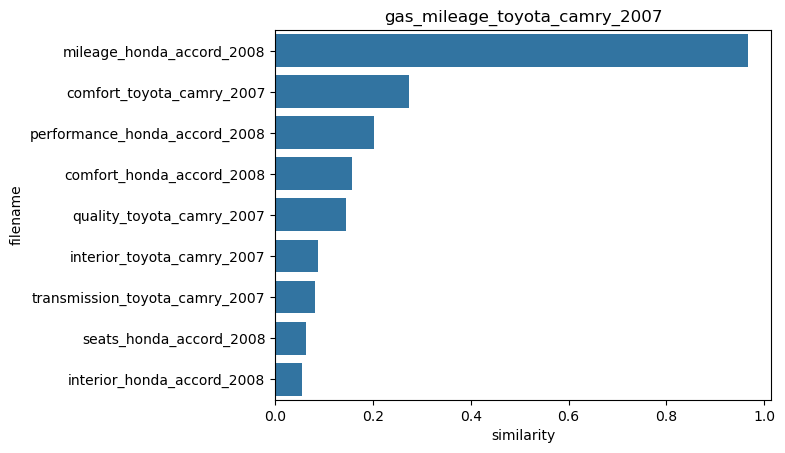

In [37]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

car_sorted_indexes = car_indexes[sorted_index.reshape(-1)]

car_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
car_1_sim_value = car_1_sim_value[1:]

car_1_sim_df = pd.DataFrame()
car_1_sim_df['filename'] = document_df.iloc[car_sorted_indexes]['filename']
car_1_sim_df['similarity'] = car_1_sim_value
print('가장 유사도가 큰 파일명 및 유사도:\n', car_1_sim_df.iloc[0, :])

sns.barplot(x='similarity', y='filename',data=car_1_sim_df)
plt.title(comparison_docname)
